In [33]:
from disease_prediction.data import datasets as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading data

In [2]:
df = ds.load_datasets(subsets=['train', 'validate', 'test'],
                       directory='/Users/rebeccaceppas/Desktop/code/disease_prediction/disease_prediction/data/')

_df = df['train']
df_test = df['test']
df_validate = df['validate']

# Pre-processing

- remove ebola from possible diseases
- turn initial evidence into dummy binary columns
- turn pain_char into dummy binaries
- turn pain somewhere into binary (yes or no only)
- turn lesion color into dummy binaries
- remove lesions peeling column (all N)
- remove pain_radiate column (all N)
- turn lesion_location to binary (yes or no only)
- turn lesion_larger_than_1cm into binary (YN now)
- turn trav1 into dummies (or YN binary) -- want to check if there are correlations between travel contries and pathologies
- swelling location turn to binary (YN only)

In [3]:
_df.info()

<class 'disease_prediction.data.datasets.DiagDataFrame'>
Index: 203008 entries, 1 to 1023494
Data columns (total 94 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   AGE                     203008 non-null  int64 
 1   SEX                     203008 non-null  object
 2   PATHOLOGY               203008 non-null  object
 3   INITIAL_EVIDENCE        203008 non-null  object
 4   swollen_nodes           203008 non-null  int64 
 5   std                     203008 non-null  int64 
 6   sweating                203008 non-null  int64 
 7   diarrhea                203008 non-null  int64 
 8   pain                    203008 non-null  int64 
 9   pain_char               203008 non-null  object
 10  pain_somewhere          203008 non-null  object
 11  pain_intensity          203008 non-null  int64 
 12  pain_radiate            203008 non-null  object
 13  pain_precise            203008 non-null  int64 
 14  pain_sudden          

In [4]:
## combining validation and training set so I can do cross-validation

df_train = pd.concat(
    [_df, df_validate],
    axis=0, 
    ignore_index=True
    )

## removing ebola from possible diseases
df_train.drop(index=df_train.loc[df_train.PATHOLOGY == 'Ebola'].index,
              inplace=True)

## removing lesion_peeling, pain_radiate columns
df_train.drop(columns=['lesions_peeling', 'pain_radiate'], inplace=True)


In [5]:
## one hot encoding

columns = list(df_train.columns)

numerical = []
categorical = []

for col in columns:

    if df_train[col].dtype == 'int64':
        numerical.append(col)

    elif df_train[col].dtype == 'object':
        categorical.append(col)

categorical.remove('PATHOLOGY')
categorical.remove('pain_somewhere')
categorical.remove('lesion_location')

In [6]:
print('categorical columns')
categorical

categorical columns


['SEX',
 'INITIAL_EVIDENCE',
 'pain_char',
 'lesion_color',
 'lesion_larger_than_1cm',
 'trav1',
 'swelling_location']

In [190]:
## splitting into features and outputs

#X_train = df_train.drop('PATHOLOGY', axis=1)
#y_train = df_train['PATHOLOGY']

In [7]:
## one-hot encoding

df_train = pd.get_dummies(df_train, 
                         columns=categorical, 
                         dtype=int)

In [8]:
## pain_somewhere, lesion_location and swelling_location -> Y or N to simplify

df_train['lesion_location'] = (df_train['lesion_location'] != 'nowhere').astype(int)
df_train['pain_somewhere'] = (df_train['pain_somewhere'] != 'nowhere').astype(int)

# Testing models

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [12]:
df_tt, df_val, = train_test_split(df_train, 
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=740,
                                            stratify=df_train.PATHOLOGY)

X_tt = df_tt.drop(columns='PATHOLOGY')
y_tt = df_tt.PATHOLOGY
X_val = df_val.drop(columns='PATHOLOGY')
y_val = df_val.PATHOLOGY

# Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [17]:
log_reg_pipe = Pipeline([('scale', StandardScaler()),
                         ('log_reg', LogisticRegression(max_iter=1000,
                                    solver='sag'))])
log_reg_pipe.fit(X_tt, y_tt)
y_pred = log_reg_pipe.predict(X_val)
classification_report(y_val, y_pred)

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


'                         precision    recall  f1-score   support\n\n     Allergic sinusitis       0.84      0.88      0.86      5668\n            Anaphylaxis       0.82      0.43      0.57      6295\n                 Chagas       1.00      0.23      0.38      2075\nHIV (initial infection)       0.38      0.51      0.44      6573\n              Influenza       0.68      0.32      0.43      6080\n        Localized edema       0.52      1.00      0.68      6304\n                    SLE       0.92      0.30      0.46      2689\n            Sarcoidosis       0.58      0.70      0.63      4863\n           Tuberculosis       0.54      0.60      0.57      3650\n         Whooping cough       1.00      1.00      1.00      1323\n\n               accuracy                           0.60     45520\n              macro avg       0.73      0.60      0.60     45520\n           weighted avg       0.67      0.60      0.59     45520\n'

In [19]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.84      0.88      0.86      5668
            Anaphylaxis       0.82      0.43      0.57      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.38      0.51      0.44      6573
              Influenza       0.68      0.32      0.43      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       0.92      0.30      0.46      2689
            Sarcoidosis       0.58      0.70      0.63      4863
           Tuberculosis       0.54      0.60      0.57      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.60     45520
              macro avg       0.73      0.60      0.60     45520
           weighted avg       0.67      0.60      0.59     45520



# K Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

ks = np.arange(1,15)

for k in ks:
    knn_pipe = Pipeline([('scale', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=k))])
    knn_pipe.fit(X_tt, y_tt)
    y_pred = knn_pipe.predict(X_val)

    print(k, '-- number of neighbors')
    print(classification_report(y_val, y_pred))
    print()

1 -- number of neighbors
                         precision    recall  f1-score   support

     Allergic sinusitis       0.77      0.72      0.74      5668
            Anaphylaxis       0.51      0.50      0.51      6295
                 Chagas       0.29      0.33      0.31      2075
HIV (initial infection)       0.35      0.36      0.36      6573
              Influenza       0.42      0.40      0.41      6080
        Localized edema       0.56      0.61      0.58      6304
                    SLE       0.40      0.40      0.40      2689
            Sarcoidosis       0.52      0.52      0.52      4863
           Tuberculosis       0.48      0.47      0.47      3650
         Whooping cough       1.00      0.93      0.96      1323

               accuracy                           0.51     45520
              macro avg       0.53      0.52      0.53     45520
           weighted avg       0.51      0.51      0.51     45520


2 -- number of neighbors
                         precision  

# Multinomial Naive Bayes


In [27]:
from sklearn.naive_bayes import MultinomialNB

alphas = np.logspace(-4, 0, 10)

for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_tt, y_tt)
    y_pred = mnb.predict(X_val)

    print('alpha =', alpha)
    print(classification_report(y_val, y_pred))
    print()



alpha = 0.0001
                         precision    recall  f1-score   support

     Allergic sinusitis       0.87      0.79      0.83      5668
            Anaphylaxis       0.88      0.41      0.56      6295
                 Chagas       0.56      0.27      0.37      2075
HIV (initial infection)       0.40      0.56      0.47      6573
              Influenza       0.56      0.34      0.42      6080
        Localized edema       0.52      0.99      0.68      6304
                    SLE       0.89      0.31      0.46      2689
            Sarcoidosis       0.59      0.67      0.63      4863
           Tuberculosis       0.51      0.54      0.53      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.59     45520
              macro avg       0.68      0.59      0.59     45520
           weighted avg       0.65      0.59      0.58     45520


alpha = 0.0002782559402207126
                         precision    rec

# LDA and QDA

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_tt, y_tt)
lda_pred = lda.predict(X_val)
print('LDA')
print(classification_report(y_val, lda_pred))
print()

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_tt, y_tt)
qda_pred = qda.predict(X_val)
print('QDA')
print(classification_report(y_val, qda_pred))
print()


LDA
                         precision    recall  f1-score   support

     Allergic sinusitis       0.91      0.82      0.86      5668
            Anaphylaxis       1.00      0.39      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.35      0.52      0.42      6573
              Influenza       0.65      0.36      0.47      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.71      0.64      4863
           Tuberculosis       0.53      0.68      0.59      3650
         Whooping cough       1.00      0.49      0.66      1323

               accuracy                           0.59     45520
              macro avg       0.75      0.55      0.57     45520
           weighted avg       0.70      0.59      0.58     45520




/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA
                         precision    recall  f1-score   support

     Allergic sinusitis       0.86      0.87      0.86      5668
            Anaphylaxis       0.98      0.39      0.56      6295
                 Chagas       0.27      0.52      0.35      2075
HIV (initial infection)       0.45      0.04      0.08      6573
              Influenza       0.60      0.45      0.52      6080
        Localized edema       0.53      0.92      0.67      6304
                    SLE       0.27      0.72      0.40      2689
            Sarcoidosis       0.93      0.39      0.55      4863
           Tuberculosis       0.45      0.80      0.57      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.56     45520
              macro avg       0.63      0.61      0.56     45520
           weighted avg       0.65      0.56      0.53     45520




# Decision Tree

In [32]:
from sklearn import tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(X_tt, y_tt)
y_pred = dt.predict(X_val)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.81      0.87      0.84      5668
            Anaphylaxis       0.64      0.52      0.57      6295
                 Chagas       0.59      0.26      0.36      2075
HIV (initial infection)       0.42      0.42      0.42      6573
              Influenza       0.53      0.36      0.42      6080
        Localized edema       0.53      0.93      0.68      6304
                    SLE       0.57      0.37      0.45      2689
            Sarcoidosis       0.60      0.61      0.60      4863
           Tuberculosis       0.52      0.53      0.52      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.59     45520
              macro avg       0.62      0.59      0.59     45520
           weighted avg       0.59      0.59      0.57     45520



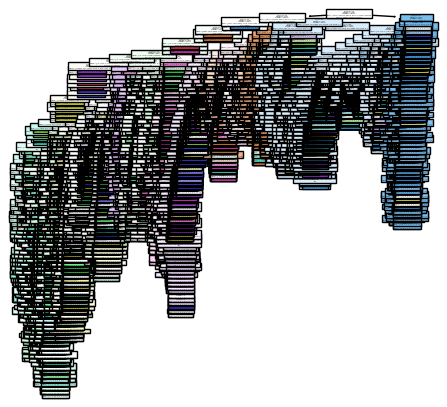

In [34]:
plt.figure(figsize = (5,5))
tree.plot_tree(dt, filled = True)
plt.show()

# Random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 20, # max_depth of each tree
    min_samples_leaf = 5, 
    bootstrap= True, # sampling with replacement
    max_samples = 2500, # number of training samples selected with replacement to build tree
    random_state = 740 # for consistency
    )

rf.fit(X_tt, y_tt)
y_pred = rf.predict(X_val)

In [36]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.86      0.87      0.86      5668
            Anaphylaxis       1.00      0.39      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.41      0.75      0.53      6573
              Influenza       0.86      0.19      0.32      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.71      0.64      4863
           Tuberculosis       0.57      0.47      0.52      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.61     45520
              macro avg       0.78      0.59      0.59     45520
           weighted avg       0.73      0.61      0.58     45520



In [41]:
score_df = pd.DataFrame({'feature':X_tt.columns,
                            'importance_score': rf.feature_importances_})

In [42]:
score_df.sort_values('importance_score', ascending=False).feature.values

array(['INITIAL_EVIDENCE_swelling', 'INITIAL_EVIDENCE_itchy_nose',
       'INITIAL_EVIDENCE_runny_nose', 'INITIAL_EVIDENCE_eye_itching',
       'INITIAL_EVIDENCE_gained_weight', 'INITIAL_EVIDENCE_cough',
       'INITIAL_EVIDENCE_cough_blood', 'INITIAL_EVIDENCE_vomiting_cough',
       'INITIAL_EVIDENCE_pain', 'INITIAL_EVIDENCE_red_eye',
       'INITIAL_EVIDENCE_convulsion', 'INITIAL_EVIDENCE_swollen_nodes',
       'INITIAL_EVIDENCE_contact_allergy',
       'INITIAL_EVIDENCE_vag_discharge', 'INITIAL_EVIDENCE_chills',
       'INITIAL_EVIDENCE_weight_loss', 'INITIAL_EVIDENCE_short_breath',
       'INITIAL_EVIDENCE_ulcers', 'INITIAL_EVIDENCE_dizziness',
       'INITIAL_EVIDENCE_stridor', 'INITIAL_EVIDENCE_lost_consciousness',
       'INITIAL_EVIDENCE_fever', 'INITIAL_EVIDENCE_coughing_fits',
       'INITIAL_EVIDENCE_lesions', 'INITIAL_EVIDENCE_fatigue',
       'INITIAL_EVIDENCE_lost_appetite',
       'INITIAL_EVIDENCE_wheezing_exhale', 'INITIAL_EVIDENCE_fatigue_ext',
       'INITIAL_EVIDENC

Note: All the first most important features are the initial evidences, as expected. Would be interesting to compare how the model does only with initial evidence, age, sex, not including any other of the symptoms.

# Baseline (frequency based)

In [51]:
most_frequent = y_tt.value_counts().index[0]
print('Most frequent disease is', most_frequent)

Most frequent disease is HIV (initial infection)


In [54]:
y_pred = [most_frequent]*len(y_val)
print(classification_report(y_val, y_pred))

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

     Allergic sinusitis       0.00      0.00      0.00      5668
            Anaphylaxis       0.00      0.00      0.00      6295
                 Chagas       0.00      0.00      0.00      2075
HIV (initial infection)       0.14      1.00      0.25      6573
              Influenza       0.00      0.00      0.00      6080
        Localized edema       0.00      0.00      0.00      6304
                    SLE       0.00      0.00      0.00      2689
            Sarcoidosis       0.00      0.00      0.00      4863
           Tuberculosis       0.00      0.00      0.00      3650
         Whooping cough       0.00      0.00      0.00      1323

               accuracy                           0.14     45520
              macro avg       0.01      0.10      0.03     45520
           weighted avg       0.02      0.14      0.04     45520



/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TO TRY:
- xG boost
- ADA boost
- CATboost
